In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [76]:
# Load combined data
df_all = pd.read_csv('runs/all_runs_combined.csv', dtype={'run_id': str})
df_configs = pd.read_csv('runs/all_configs_combined.csv', dtype={'run_id': str})

# Ensure run_id is formatted with leading zeros
df_all['run_id'] = df_all['run_id'].astype(str).str.zfill(2)
df_configs['run_id'] = df_configs['run_id'].astype(str).str.zfill(2)

print("Available runs:")
print(df_configs[['run_id', 'learning_rate', 'epsilon_starting_value', 'epsilon_decay_value']].to_string(index=False))
print(f"\nUnique run_ids in data: {df_all['run_id'].unique()}")

Available runs:
run_id  learning_rate  epsilon_starting_value  epsilon_decay_value
    01         0.0001                     1.0               0.9950
    02         0.0010                     1.0               0.9950
    03         0.0100                     1.0               0.9950
    04         0.0001                     0.2               1.0000
    05         0.0001                     0.1               1.0000
    06         0.0001                     0.5               0.9950
    07         0.0001                     0.5               0.9975
    08         0.0001                     1.0               0.9950
    09         0.0001                     1.0               0.9950
    10         0.0001                     1.0               0.9950
    11         0.0001                     1.0               0.9950
    12         0.0001                     1.0               0.9950
    13         0.0001                     1.0               0.9950
    14         0.0001                     1.0 

## Select Runs to Compare

Modify the list below to select which runs you want to compare (2, 3, or 4 runs).
Each run will be displayed with a different color and label.

In [77]:
# ========== MODIFY THIS LIST TO SELECT RUNS TO COMPARE ==========

selected_runs = ['01', '05']  # Compare different max_grad_norm values
# Examples:
# selected_runs = ['02', '04', '05']  # Compare epsilon strategies
# selected_runs = ['01', '02', '03', '04']  # Compare 4 runs
# =================================================================

# Define labels and markers for each run
run_labels = {
    # DQN - Learning Rate
    '01': 'DQN LR=0.0001',
    '02': 'DQN LR=0.001',
    '03': 'DQN LR=0.01',
    # DQN - Epsilon strategies
    '04': 'DQN Eps fix 0.2',
    '05': 'DQN Eps fix 0.1',
    '06': 'DQN Eps decay 0.5',
    '07': 'DQN Eps decay slow 0.5',
    # DQN - Buffer size
    '08': 'DQN Buffer 64',
    '09': 'DQN Buffer 300k',
    '10': 'DQN Buffer 1k',
    # DQN - Hard update frequencies
    '11': 'DQN Hard freq=1000',
    '12': 'DQN Hard freq=5000',
    '13': 'DQN Hard freq=10',
    '14': 'DQN Hard freq=1',
    '15': 'DQN Hard freq=100',
    # DQN - Tau variations
    '16': 'DQN Tau=0.01',
    '17': 'DQN Tau=0.1',
    # DDQN
    '18': 'DDQN LR=0.0001',
    '19': 'DDQN LR=0.001',
    '20': 'DDQN Hard freq=10',
    '21': 'DDQN Hard freq=100',
    '22': 'DDQN Hard freq=10 Buf=100k',
    # REINFORCE
    '23': 'REINFORCE no baseline',
    '24': 'REINFORCE baseline vLR=0.001',
    '25': 'REINFORCE baseline vLR=0.005',
    '26': 'REINFORCE baseline vLR=0.0025',
    # A2C
    '27': 'A2C 1env 1step',
    '28': 'A2C 5env 8step',
    '29': 'A2C 5env 1step',
    '30': 'A2C 5env LR=0.0005',
    '31': 'A2C 5env grad=0.5',
    '32': 'A2C 5env grad=2.0',
    '33': 'A2C 1env 5step LR=0.0001',
    '34': 'A2C 1env 10step grad=1.0',
    '35': 'A2C 1env 10step vLR=0.0005',
    '36': 'A2C 1env 5step vLR=0.0005',
    '37': 'A2C 1env 5step no grad clip',
    '38': 'A2C 1env 10step grad=2.0',
    '39': 'A2C 1env 10step LR=0.0005',
    '40': 'A2C 1env 10step vLR=0.0005',
    # REINFORCE with grad clipping
    '41': 'REINFORCE no base grad=2.0',
    '42': 'REINFORCE no base grad=3.0',
    '43': 'REINFORCE base grad=3.0',
    '44': 'REINFORCE base grad=5.0',
    '45': 'REINFORCE base grad=10.0',
    '46': 'REINFORCE no base grad=10.0',
    '47': 'REINFORCE no base grad=5.0',
    '48': 'REINFORCE no base grad=2.0',
    '49': 'REINFORCE base vLR=0.0025 grad=2.0',
    # A2C additional
    '50': 'A2C 1env 10step vLR=0.001 grad=2.0',
    # REINFORCE lower LR
    '51': 'REINFORCE no base LR=0.001 grad=2.0',
    # DQN additional
    '52': 'DQN LR=0.0005'
}

# Markers for plots (cycling through available markers)
markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', 'H', 'D', 'X', 'P', '+', 'x', '1', '2', '3', '4', '8', '<', '>', '.']
run_markers = {f'{i:02d}': markers[(i-1) % len(markers)] for i in range(1, 53)}

print(f"\nComparing {len(selected_runs)} runs: {', '.join(selected_runs)}")


Comparing 2 runs: 01, 05


## Training Comparison Visualization

Two plots side by side:
- **Left**: Learning curves with moving average
- **Right**: Success rate over time

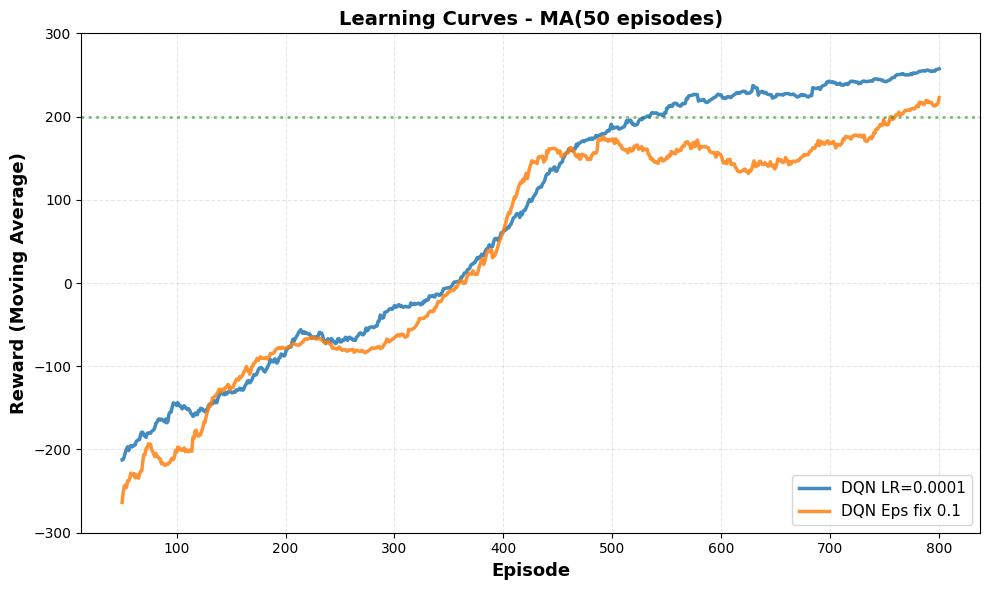

In [78]:
# Create comparison plot - Learning Curves with Moving Average
fig, ax = plt.subplots(figsize=(10, 6))
window = 50

for run_id in selected_runs:
    # Filter data for this run and reset index
    run_data = df_all[df_all['run_id'] == run_id].copy().reset_index(drop=True)
    
    # Calculate moving average
    run_data['reward_ma'] = run_data['reward'].rolling(window=window).mean()
    
    # Plot (let matplotlib choose colors automatically)
    ax.plot(
        run_data['episode'], 
        run_data['reward_ma'], 
        linewidth=2.5, 
        label=run_labels.get(run_id, f'Run {run_id}'), 
        alpha=0.85
    )

ax.set_xlabel('Episode', fontsize=13, fontweight='bold')
ax.set_ylabel('Reward (Moving Average)', fontsize=13, fontweight='bold')
ax.set_title(f'Learning Curves - MA({window} episodes)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([-300, 300])
ax.axhline(y=200, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Target (200)')

plt.tight_layout()
plt.show()

## Individual Episode Outcomes

Scatter plot showing each episode reward, colored by outcome type (success, crash, out of bounds, truncated).

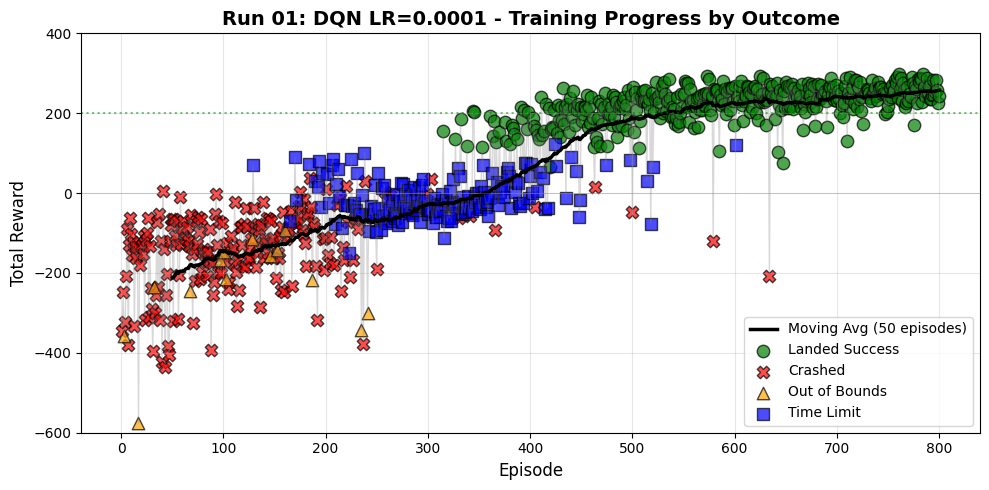


📊 Run 01 Statistics:
  Average Reward: 69.278
  Max Reward: 299.140
  Min Reward: -575.480
  Std Dev: 175.516
  Success Rate: 49.9%
------------------------------------------------------------


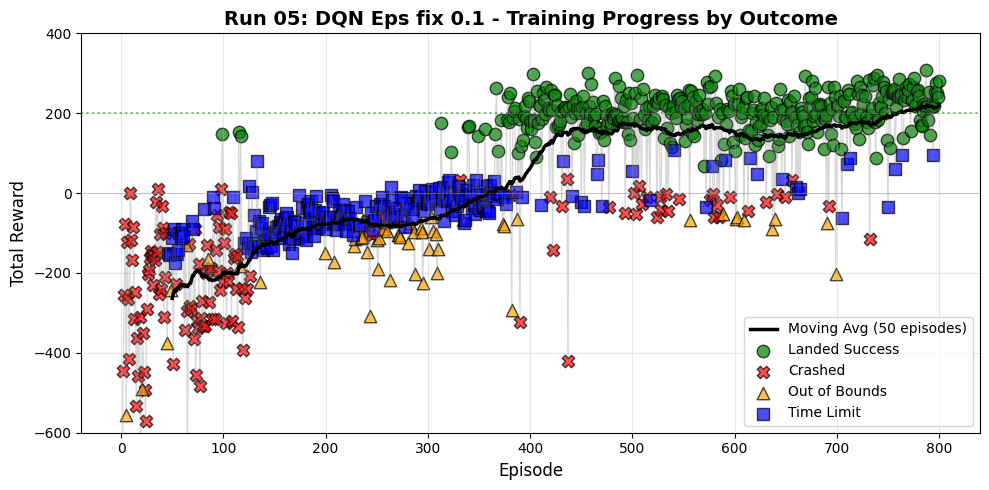


📊 Run 05 Statistics:
  Average Reward: 36.959
  Max Reward: 307.930
  Min Reward: -1038.500
  Std Dev: 182.183
  Success Rate: 45.5%
------------------------------------------------------------


In [79]:
# Color and marker mapping for outcomes (same style as DQN_train)
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'orange', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

# Create one figure per run (not stacked - full width each)
for run_id in selected_runs:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Filter data for this run
    run_data = df_all[df_all['run_id'] == run_id].copy().reset_index(drop=True)
    
    # Base line plot (rewards connected)
    ax.plot(run_data['episode'], run_data['reward'], alpha=0.3, linewidth=1, color='gray')
    
    # Plot moving average
    run_data['reward_ma'] = run_data['reward'].rolling(window=window).mean()
    ax.plot(run_data['episode'], run_data['reward_ma'], linewidth=2.5, 
            label=f'Moving Avg ({window} episodes)', color='black')
    
    # Plot scatter points with different markers for each outcome
    for outcome, style in outcome_styles.items():
        outcome_data = run_data[run_data['outcome'] == outcome]
        if len(outcome_data) > 0:
            ax.scatter(
                outcome_data['episode'], 
                outcome_data['reward'], 
                c=style['color'], 
                marker=style['marker'], 
                label=style['label'], 
                s=80, 
                alpha=0.7, 
                edgecolors='black', 
                linewidth=1
            )
    
    # Styling
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Total Reward', fontsize=12)
    ax.set_title(f'Run {run_id}: {run_labels.get(run_id, "")} - Training Progress by Outcome', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-600, 400])
    ax.axhline(y=200, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this run
    print(f"\n📊 Run {run_id} Statistics:")
    print(f"  Average Reward: {run_data['reward'].mean():.3f}")
    print(f"  Max Reward: {run_data['reward'].max():.3f}")
    print(f"  Min Reward: {run_data['reward'].min():.3f}")
    print(f"  Std Dev: {run_data['reward'].std():.3f}")
    print(f"  Success Rate: {(run_data['outcome'] == 'landed_success').sum() / len(run_data) * 100:.1f}%")
    print("-" * 60)

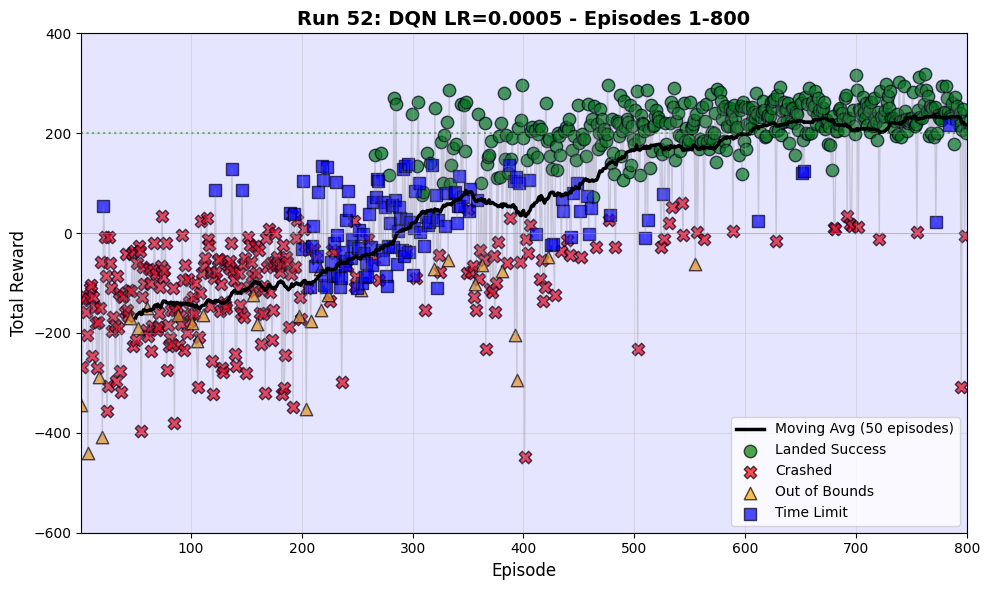


📊 Run 52 Statistics (Episodes 1-800):
  Average Reward: 67.050
  Max Reward: 317.630
  Min Reward: -449.280
  Std Dev: 169.234
  Success Rate: 48.2%
------------------------------------------------------------


In [80]:
# ========== RUN AND EPISODE WINDOW SELECTION ==========
run_to_display = '52'  # Select which run to display
episode_start = 1      # First episode to display
episode_end = 800      # Last episode to display
# =======================================================

# Color and marker mapping for outcomes
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'orange', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

fig, ax = plt.subplots(figsize=(10, 6))

# Filter data for this run
run_data = df_all[df_all['run_id'] == run_to_display].copy().reset_index(drop=True)

# Filter by episode window
run_data_window = run_data[(run_data['episode'] >= episode_start) & (run_data['episode'] <= episode_end)]

# Base line plot (rewards connected)
ax.plot(run_data_window['episode'], run_data_window['reward'], alpha=0.3, linewidth=1, color='gray')

# Plot moving average (calculated on full data, then filtered)
run_data['reward_ma'] = run_data['reward'].rolling(window=window).mean()
run_data_ma_window = run_data[(run_data['episode'] >= episode_start) & (run_data['episode'] <= episode_end)]
ax.plot(run_data_ma_window['episode'], run_data_ma_window['reward_ma'], linewidth=2.5, 
        label=f'Moving Avg ({window} episodes)', color='black')

# Plot scatter points with different markers for each outcome
for outcome, style in outcome_styles.items():
    outcome_data = run_data_window[run_data_window['outcome'] == outcome]
    if len(outcome_data) > 0:
        ax.scatter(
            outcome_data['episode'], 
            outcome_data['reward'], 
            c=style['color'], 
            marker=style['marker'], 
            label=style['label'], 
            s=80, 
            alpha=0.7, 
            edgecolors='black', 
            linewidth=1
        )

# Styling - FIXED AXES
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Reward', fontsize=12)
ax.set_title(f'Run {run_to_display}: {run_labels.get(run_to_display, "")} - Episodes {episode_start}-{episode_end}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

# Fixed axis limits
ax.set_xlim([1, 800])
ax.set_ylim([-600, 400])

ax.axhline(y=200, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add shaded region for selected window
ax.axvspan(episode_start, episode_end, alpha=0.1, color='blue')

plt.tight_layout()
plt.show()

# Print statistics for the selected window
print(f"\n📊 Run {run_to_display} Statistics (Episodes {episode_start}-{episode_end}):")
print(f"  Average Reward: {run_data_window['reward'].mean():.3f}")
print(f"  Max Reward: {run_data_window['reward'].max():.3f}")
print(f"  Min Reward: {run_data_window['reward'].min():.3f}")
print(f"  Std Dev: {run_data_window['reward'].std():.3f}")
print(f"  Success Rate: {(run_data_window['outcome'] == 'landed_success').sum() / len(run_data_window) * 100:.1f}%")
print("-" * 60)